
# Multi-objective Bayesian Optimization


TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 25

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

from copy import deepcopy

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators import MGGPOGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs


evaluator = Evaluator(function=evaluate_TNK)
evaluator.max_workers = 10

# test check options
vocs = deepcopy(tnk_vocs)
gen = MGGPOGenerator(vocs)
gen.options.acq.reference_point = {"y1":1.5,"y2":1.5}
gen.options.acq.monte_carlo_samples = NUM_MC_SAMPLES
gen.options.optim.num_restarts = NUM_RESTARTS
X = Xopt(evaluator=evaluator, generator=gen, vocs=vocs)
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.75, 1.0]}))

X


            Xopt
________________________________
Version: 0+untagged.1.gf976f4f
Data size: 2
Config as YAML:
xopt: {asynch: false, strict: false, dump_file: null, max_evaluations: null}
generator:
  name: mggpo
  optim: {num_restarts: 25, raw_samples: 20, sequential: true, max_travel_distances: null,
    use_turbo: false}
  acq:
    proximal_lengthscales: null
    use_transformed_proximal_weights: true
    monte_carlo_samples: 128
    reference_point: {y1: 1.5, y2: 1.5}
    population_size: 64
  model:
    name: standard
    custom_constructor: null
    use_low_noise_prior: true
    covar_modules: {}
    mean_modules: {}
  n_initial: 3
  use_cuda: false
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  max_workers: 10
  function_kwargs: {sleep: 0, random_sleep: 0, raise_probability: 0}
  vectorized: false
vocs:
  variables:
    x1: [0.0, 3.14159]
    x2: [0.0, 3.14159]
  constraints:
    c1: [GREATER_THAN, 0.0]
    c2: [LESS_THAN, 0.5]
  objectives: {y1: MINIMIZ

In [2]:
for i in range(10):
    print(i)
    X.step()

0
1
2
3
4
5
6
7
8
9


In [3]:
X.generator.data

,x1,x2,y1,y2,c1,c2,some_array,xopt_runtime,xopt_error,a
1,1.000000,0.750000,1.000000,0.750000,0.626888,0.312500,"[1, 2, 3]",0.000067,False,NaN
2,0.750000,1.000000,0.750000,1.000000,0.626888,0.312500,"[1, 2, 3]",0.000017,False,NaN
3,0.384812,2.439298,0.384812,2.439298,5.178577,3.774146,"[1, 2, 3]",0.000063,False,dummy_constant
4,0.487532,2.448830,0.487532,2.448830,5.334454,3.798093,"[1, 2, 3]",0.000029,False,dummy_constant
5,0.229701,2.465688,0.229701,2.465688,5.123935,3.936991,"[1, 2, 3]",0.000010,False,dummy_constant
...,...,...,...,...,...,...,...,...,...,...
98,0.307949,0.946867,0.307949,0.946867,-0.039937,0.236574,"[1, 2, 3]",0.000008,False,dummy_constant
99,0.307949,0.962809,0.307949,0.962809,-0.001995,0.251076,"[1, 2, 3]",0.000008,False,dummy_constant
100,0.307949,0.964008,0.307949,0.964008,0.000876,0.252187,"[1, 2, 3]",0.000007,False,dummy_constant
101,0.249841,0.985275,0.249841,0.985275,0.100537,0.298071,"[1, 2, 3]",0.000008,False,dummy_constant


## plot results


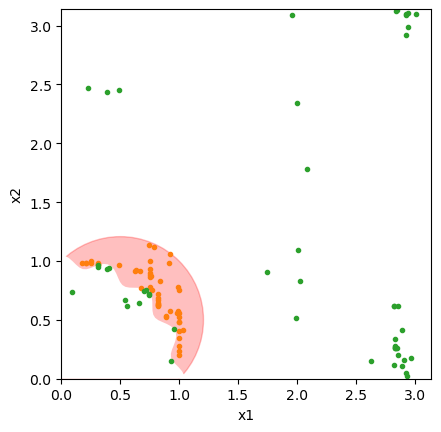

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

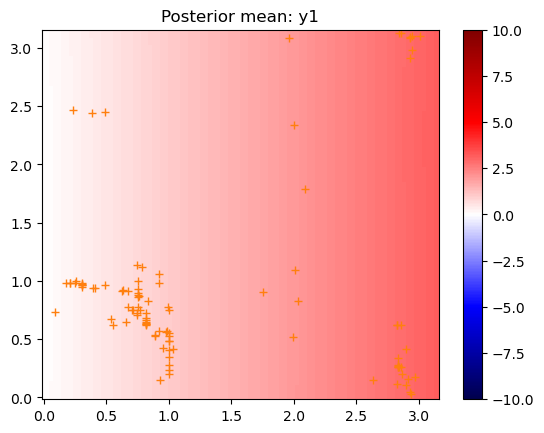

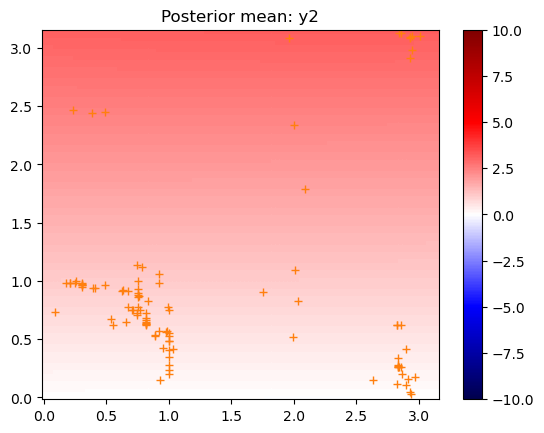

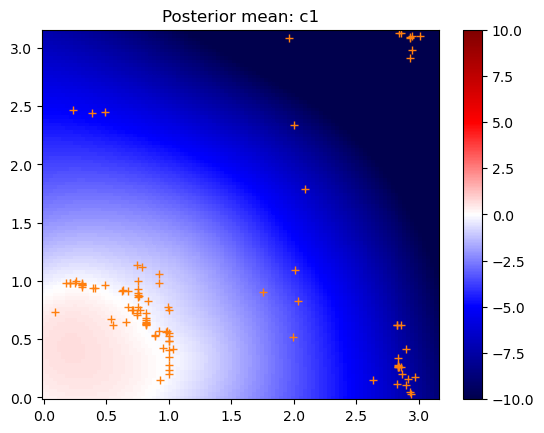

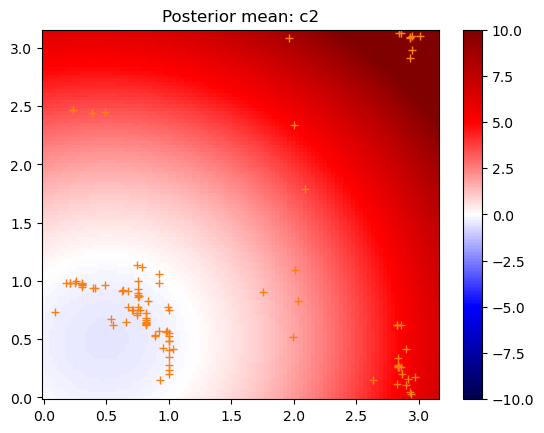

In [5]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.train_model(X.generator.data)

# create mesh
n = 100
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    for i in range(len(vocs.output_names)):
        mean = post.mean[...,i]
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "+C1")
        c = ax.pcolor(
            xx, yy, mean.squeeze().reshape(n, n),
            cmap="seismic",
            vmin=-10.0,
            vmax=10.0)
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

[[0.67588619 0.82347939]]


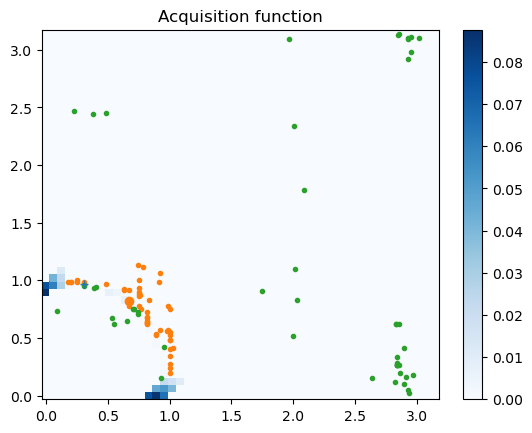

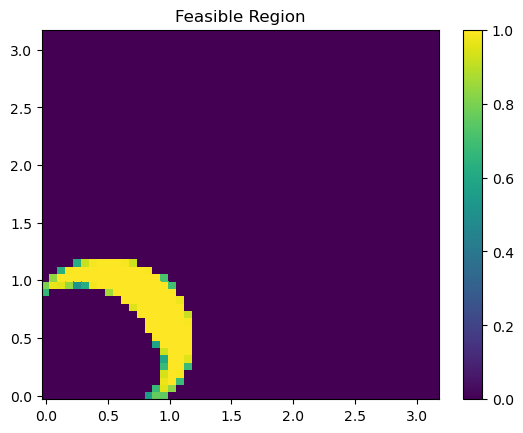

In [6]:
# plot the acquisition function
from xopt.generators.bayesian.objectives import feasibility

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 50
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n), cmap="Blues")
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
    ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

    ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, tnk_vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")

candidate = X.generator.generate(1)
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")